# Compute Matches (Faithfulness) between Two NR simulations from different groups
<center> Here we will use matches to compare the q4 nonspinning case from GaTech and BAM </center>

#### Notes:
 * SXS cases to be considered in the future?

## Setup Environment

In [1]:
# Setup ipython environment
%load_ext autoreload
%autoreload 2
# %matplotlib auto
%matplotlib inline
# Import useful things
#
# from os import system
# system('source ~/.virtual_enviroments/ringdownFD_nikhef/bin/activate')
from nrutils.core.basics import lalphenom
from kerr import rgb,gmvpfit,modelrd,anglep,qnmfit,leaver,ndflatten,sunwrap,alert,cyan,slm,ysprod,ssprod
from kerr.models import mmrdns
from kerr.models import mmrdnp
from nrutils import scsearch,gwylm,FinalSpin0815,EradRational0815
# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
#
import corner
#
from numpy import *
from numpy.linalg import pinv
#
from nrutils.core.units import *
#
from scipy.optimize import minimize
from os.path import expanduser
#
import lal
from lal import MSUN_SI, PC_SI, C_SI, G_SI, MTSUN_SI
import lalsimulation as lalsim
alert('The LASIMULATION version is located at: %s'%( bold(yellow(lalsim.__path__[0])) ))
#
import review_ringdownFD_nikhef as review
from nrutils.analyze.match import match as match_object
from scipy.interpolate import InterpolatedUnivariateSpline as spline
#
plotdir = '/Users/book/KOALA/review_ringdownFD_nikhef/gallery/'

(<module>)>> The LASIMULATION version is located at: /Users/book/.virtual_enviroments/ringdownFD_nikhef/opt/lalsuite/lib/python2.7/site-packages/lalsimulation


## Find the simulations of interest

Note:
 * here we apply the RIT remnant fits to the simulation metadata as BAM runs do not have reliable final mass and spin values from their post-processing.
 * There are multiple resolutions for each case, so more checks are possible

In [3]:
# Find simlations to load 
alert('Searching for GT simulation',header=True)
A = scsearch(q=4,institute='gt',nonspinning=True,verbose=True, apply_remnant_fit=True)
alert('Searching for BAM simulation',header=True)
B = scsearch(q=4,institute='bam',nonspinning=True,verbose=True, apply_remnant_fit=True)


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(<module>)>> Searching for GT simulation
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(scsearch)>> Found apply_remnant_fit (=True) keyword.
(scsearch)>> Found institute (='gt') keyword.
(scsearch)>> Found nonspinning (=True) keyword.
(scsearch)>> Found q (=4) keyword.
(scsearch)>> Found verbose (=True) keyword.
(scsearch!)>> Applying remant fit to scentry objects. This should be done if the final mass and spin meta data are not trustworth. The fit being used only works for non-precessing systems.
## Found 8 possibly degenerate simulations:
[0001][bradwr] HRq-series: ns-q4.00	(D9_q4.0_a0.0_m160)
[0002][bradwr] HR-series: ns-q4.00	(D10_q4.00_a0.0_0.0_m240)
[0003][bradwr] HR-series: ns-q4.00	(D11_q4.00_a0.0_m200)
[0004][bradwr] HR-series: ns-q4.00	(D11_q4.00_a0.0_m180)
[0005][bradwr] HR-series: ns-q4.00	(D11_q4.00_a0.0_m160)
[0006][bradwr] HR-series: ns-q4.00	(D09_q4.00_a0.0_m160)
[0007][bradwr] HR-series: ns-q4.00	(D09_q4

## Load simulation data

Here we will select the highest resoluation simulations for this case. Note that common time resolution is used to help with setting up common domains for matching.

In [38]:
# Load simulation data
a,b = A[0],B[0]
# y = gwylm( a, lm=[(2,2)], verbose=True )
lmlist = []
for lm in [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5)]:
    l,m = lm; 
    lmlist+=[(l,m)]; lmlist+=[(l,-m)]
alert('Loading GT simulation ...',header=True)
y = gwylm( a, lm=lmlist, verbose=True, clean=True, pad=500, dt=0.25 )
alert('Loading BAM simulation ...',header=True)
g = gwylm( b, lm=lmlist, verbose=True, clean=True, pad=500, dt=0.25 )


# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #
(<module>)>> Loading GT simulation ...
# -~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~ #

(gwylm)>> Found clean (=True) keyword.
(gwylm)>> Found dt (=0.25) keyword.
(gwylm)>> Found lm (=[(2, 2), (2, -2), (2, 1), (2, -1), (3, 3), (3, -3), (3, 2), (3, -2), (4, 4), (4, -4), (4, 3), (4, -3), (5, 5), (5, -5)]) keyword.
(gwylm)>> Found pad (=500) keyword.
(gwylm)>> Found scentry_obj (=<nrutils.core.nrsc.scentry instance at 0x109b65908>) keyword.
(gwylm)>> Found verbose (=True) keyword.
(validate!)>> Multiple catalog directories found. We will scan through the related list, and then store first the catalog_dir that the OS can find.
(validate!)>> Selecting "/Volumes/athena/bradwr/"
(gwylm)>> The (extraction_parameter,level) is (75.0,None), which differs from the config values of (75,0). You have either manually input the non-config values, or the handler has set them by looking at the contents of the simulation directory. 
(__make_lmlist

## Extract Ringdown

In [39]:
# Extract Ringdown
yrd = y.ringdown(T0=10,T1=200,use_peak_strain=False,verbose=True)
grd = g.ringdown(T0=10,T1=200,use_peak_strain=False,verbose=True)

(ringdown)>> Time will be listed relative to the peak of luminosity.
(ringdown)>> Time will be listed relative to the peak of luminosity.


## Quickly compare a multipole between simulations

761 761
0.25 0.25
gt
(align)>> Performing sky-averaged match (no noise curve) to estimate optimal shift in orbital phase.


/Users/book/JOKI/Libs/KOALA/nrutils_dev/nrutils/core/basics.py:71: RuntimeWarning: divide by zero encountered in double_scalars
  if abs(delta-d)/(delta+d) < 1e-6:


(align)>> Obtaining numerical estimate of optimal shift in orbital phase.
(rotate!)>> Note that this method only affects waveforms, meaning that rotations are not back propagated to metadata: spins, component positions etc. This is for future work. Call rotate with verbose=False to disable this message.
(align)>> (dphi_opt,dpsi_opt) = (0.7872,3.1387)


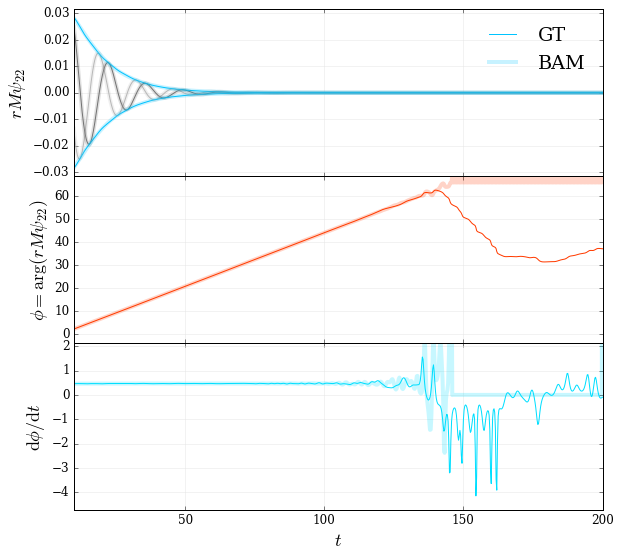

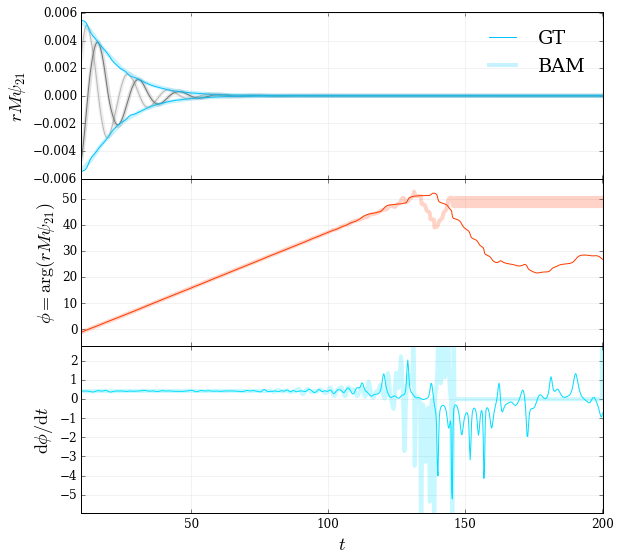

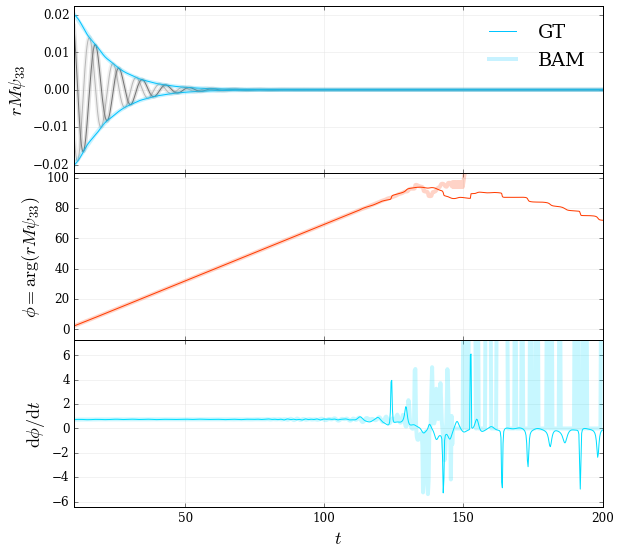

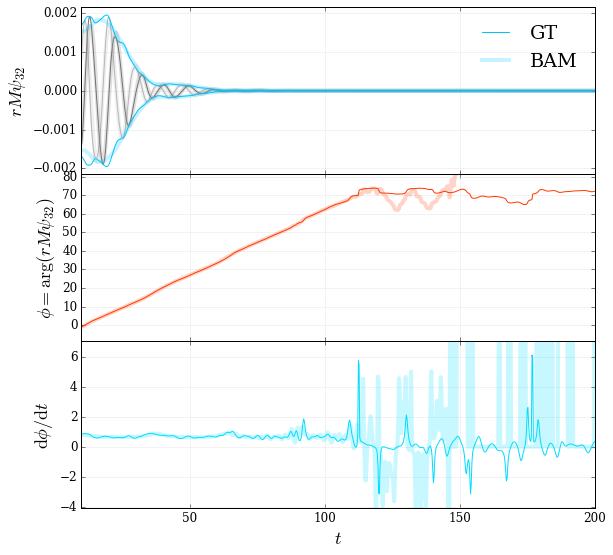

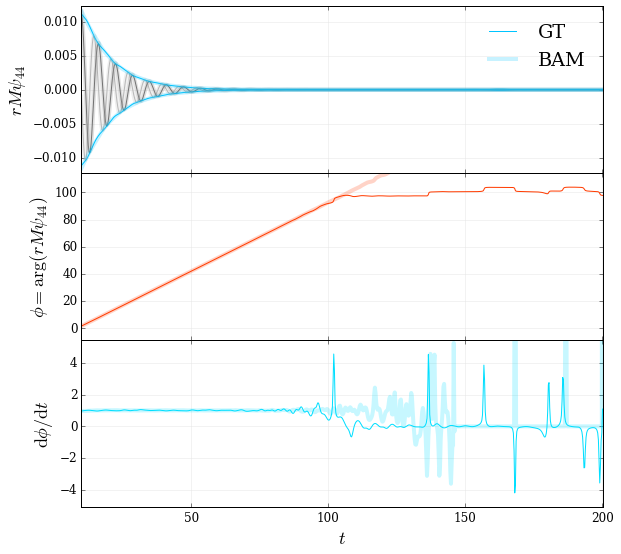

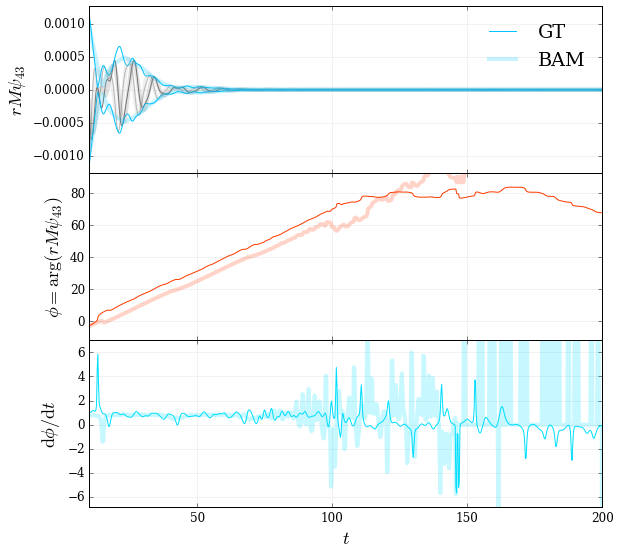

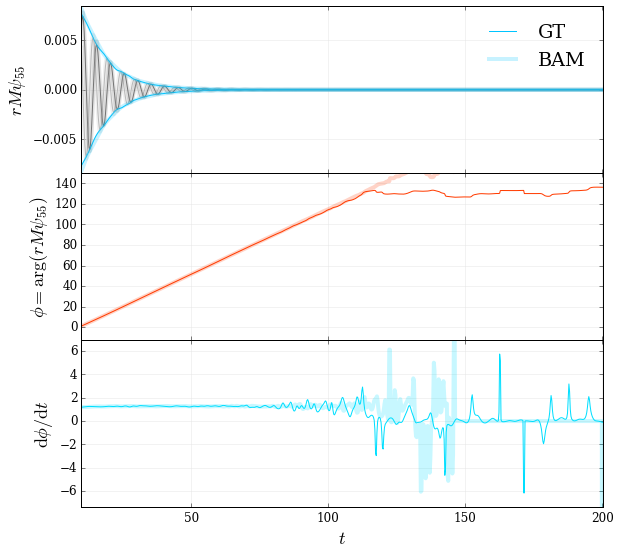

In [71]:
print len(yrd.lm[2,2]['strain'].t), len(grd.lm[2,2]['strain'].t)
print yrd.lm[2,2]['strain'].dt, grd.lm[2,2]['strain'].dt
print yrd.config.institute

yrd.align(grd)

for ll,mm in [(2,2),(2,1),(3,3),(3,2),(4,4),(4,3),(5,5)]:
    yrd.lm[ll,mm]['psi4'].plot(ref_gwf=grd.lm[ll,mm]['psi4'],labels=['GT','BAM'])

## Define Constants for Physical Units

In [55]:
# Define physical parameters for LAL comparison
M_Sol = 150
Mf_Sol = M_Sol * y.mf
D_Mpc = 150
# Not all of these are used here.
inclination = pi/4
fmin = 20
phi_ref = pi/3
#
M = M_Sol*MSUN_SI
Mf = Mf_Sol*MSUN_SI
D = D_Mpc*1.0e6*PC_SI
#
t_code = yrd.lm[2,2]['strain'].t
deltaT = physt( diff(t_code)[0], M_Sol )
t = physt(t_code,M_Sol)
xf = y.xf
eta = y.eta
#
df = physf( yrd.lm[2,2]['strain'].df, M_Sol )
code_f = yrd.lm[2,2]['strain'].f
f  = physf( code_f, M_Sol )
#
fmin,fmax=30.0,1500.0
fmask = (f>=fmin) & (f<=fmax)

## Define high level waveform generators

In [56]:
#

# MAYA (GT)
def signal_wfarr_fun( THETA,PHI,LM=None) : 
    ans = physhf( yrd.recompose( THETA,PHI,kind='strain',domain='freq').fd_wfarr[fmask,:], M_Sol, D_Mpc ) 
    return ans

# BAM
def template_wfarr_fun( THETA,PHI,LM=None):
    ans = physhf( grd.recompose( THETA,PHI,kind='strain',domain='freq').fd_wfarr[fmask,:], M_Sol, D_Mpc ) 
    return ans

## Plot polarizations for sample configuration

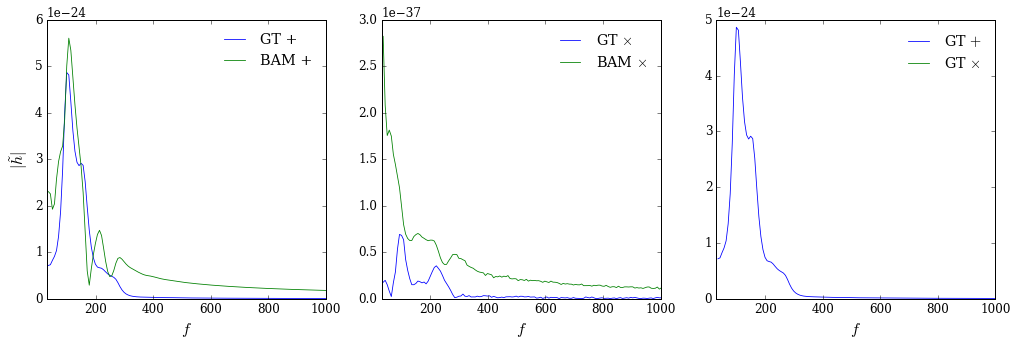

In [57]:
#
theta,phi = pi/2, 0
template = template_wfarr_fun( theta, phi )
signal =   signal_wfarr_fun(   theta, phi )

#
figure( figsize=5*array([3.4,1]) )

#
def plotpc(data,k=1,label=''):
    xl = [30,1000]
    plot( f[fmask], abs(data[:,k]), label=label )
    xlim(xl)
    legend(frameon=False)
    xlabel('$f$')

#
subplot(1,3,1)
plotpc(template,1,'GT +')
plotpc(signal,1,'BAM +')
ylabel(r'$|\tilde{h}|$')
#
subplot(1,3,2)
plotpc(template,2,r'GT $\times$')
plotpc(signal,2,r'BAM $\times$')
#
subplot(1,3,3)
plotpc(template,1,r'GT $+$')
plotpc(template,2,r'GT $\times$')

## Match Setup

#### Initialize match object and plot waveforms on noise curve

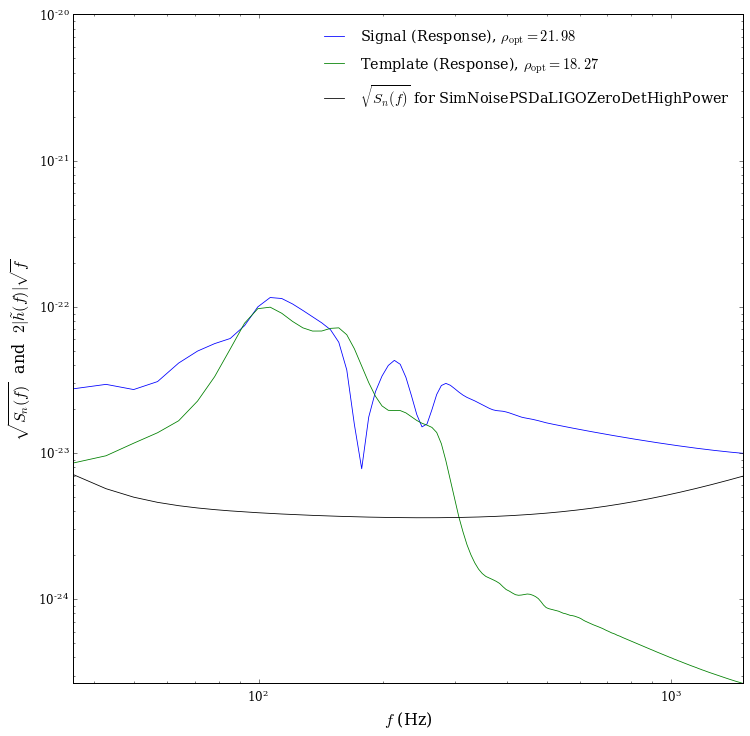

In [58]:
#--%--%--%--%--%--%--%--%--%--%--%--#
# Construct match object
#--%--%--%--%--%--%--%--%--%--%--%--#
mo = match_object( template, signal, fmin=fmin, fmax=fmax, signal_polarization=0, positive_f=True, psd_thing = lalsim.SimNoisePSDaLIGOZeroDetHighPower )
mo.plot()

## Test Optimization over template orbital phase

 
Result of notebook for-loop method:
----------------------------------------


/Library/Python/2.7/site-packages/ipykernel/__main__.py:29: ComplexWarning: Casting complex values to real discards the imaginary part


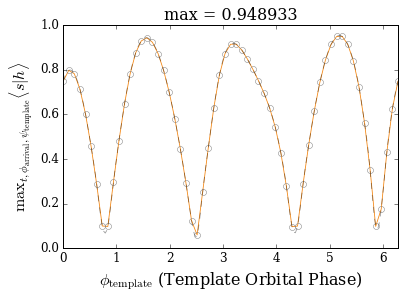


Result of class method:
----------------------------------------
NOTE: This method uses intrp_max to get a better peak location.


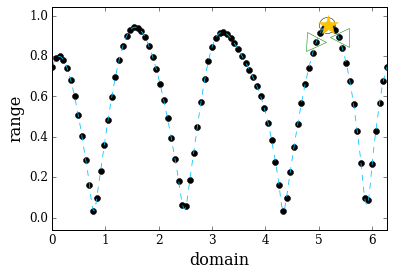

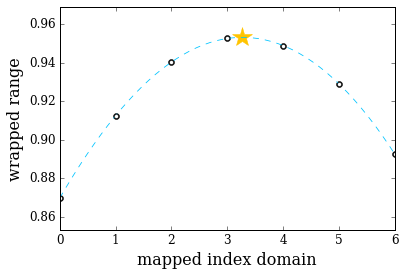

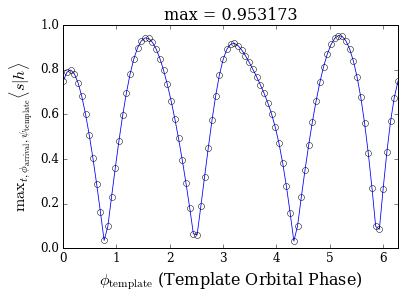

In [61]:
figure()
    
phi_range = linspace(0,2*pi,61)
# print 'yo! --> ',physf(y.ylm[0].df,M)
# template_wfarr_fun = lambda PHI: physhf( z.recompose(theta, PHI, select_lm=select_lm), M, D ) 
template_phi_wfarr_fun = lambda PHI: template_wfarr_fun( theta, PHI )
# template_phi_wfarr_fun = lambda PHI: lalphenomhm( y.eta,M,y.X1[-1],y.X2[-1],theta,PHI,D,phys_df,fmin,fmax )


# 
matchlist = []
for phi in phi_range:
    # 
    mo.apply( template_wfarr = template_phi_wfarr_fun(phi) )
    matchlist.append(  mo.brute_match(timeoptoff=True) )
    # matchlist.append(  mo.calc_template_pol_optimized_match() )

#
print '\nResult of notebook for-loop method:\n%s'%(20*'--')

plot( phi_range, matchlist, marker='o', color='#f48713', mfc='none', mec=0.5*ones(3) )
phi_ = linspace(0,2*pi,2e2)
plot( phi_, spline(phi_range,matchlist)(phi_), '--k', alpha=0.4 )
    
xlabel(r'$\phi_{\mathrm{template}}$ (Template Orbital Phase)')
xlim(lim(phi_))
# title('$\psi_{\mathrm{signal}} = %1.2f$'%mo.signal['polarization'])
ylabel(r'$ \operatorname{max}_{t,\phi_{\mathrm{arrival}},\psi_{\mathrm{template}}} \langle s | h \rangle$')
title('max = %f'%max(matchlist) )
# title(r'Optimized over $\psi_{\mathrm{template}}$')
show()

print '\nResult of class method:\n%s\nNOTE: This method uses intrp_max to get a better peak location.'%(20*'--')
mo.calc_template_phi_optimized_match( template_phi_wfarr_fun, method='numerical', timeoptoff=True, plot=True );

## Compute many matches over signal extrensic parameters

In [62]:
match_info = mo.calc_match_sky_moments( signal_wfarr_fun,
                                        template_wfarr_fun, 
                                        N_theta = 13, 
                                        N_psi_signal = 11, 
                                        N_phi_signal = 11,
                                        method = 'numerical',
                                        timeoptoff = True,
                                        verbose = True )

(calc_match_sky_moments)>> theta = 0.01
----------------------------------------
>> working  . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . ,  done.
>>  min_match 	 = 	 0.999990
>>  avg_match 	 = 	 0.999994
snr_avg_match 	 = 	 0.999994
>>  max_match 	 = 	 0.999999
----------------------------------------
(calc_match_sky_moments)>> theta = 0.27
----------------------------------------
>> working  . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . , . . . . . . . . . . . ,  done.
>>  min_match 	 = 	 0.999943
>>  avg_match 	 = 	 0.999991
snr_avg_match 	 = 	 0.999991
>>  max_match 	 = 	 0.999999

In [63]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

(mkdir)>> Directory at "/Users/book/Desktop/issue6_D9_q4.0_a0.0_m160/data/" does not yet exist and will be created.
[ 0.0009989  0.001    ]


NameError: name 'NOTEBOOK_FULL_PATH' is not defined

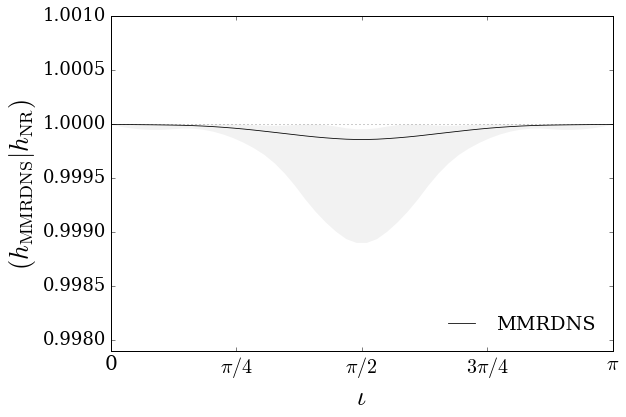

In [64]:
import pickle

#
outdir = '/Users/book/Desktop/issue6_'+y.simname+'/'
datadir = outdir + 'data/'
mkdir(datadir,verbose=True)

#
filepath = datadir + 'match_info.pickle'


# with open( '/Users/book/GARREG/REPOS/PhenomHM/workflows/matches/data/q2_-0.5_-0.5_96_460/data/match_info.pickle' , 'rb') as datafile:
#     match_info = pickle.load( datafile )

#
with open(filepath, 'wb') as datafile:
    pickle.dump( match_info , datafile, pickle.HIGHEST_PROTOCOL )

# #
# for k in match_info:
#     savetxt( datadir+k+'.asc', match_info[k] )
    

# Setup plotting backend
import matplotlib as mpl
from mpl_toolkits.mplot3d import axes3d
mpl.rcParams['lines.linewidth'] = 0.8
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelsize'] = 26
mpl.rcParams['axes.titlesize'] = 20    
    
a = match_info

figure( figsize = 6*array([1.5,1]) )

#
alpha = 0.05
sth = linspace(0,pi)
sm = lambda x: spline( a['theta'], a[x], k=2 )(sth)
fill_between( sth, sm('min'), sm('max'), color='k', alpha=alpha, edgecolor='none' )
# fill_between( sth, sm('quadrupole_min'), sm('quadrupole_max'), color='k', alpha=alpha, edgecolor='none' )
plot( sth, sm('weighted_avg'),'-k',label='MMRDNS' )
# plot( sth, sm('quadrupole_weighted_avg'),'--k',label='PhenomD' )


#
hline = [0.97,0.98,0.99,1.0]
for val in hline:
    axhline(val,linestyle=':',color='k',alpha=0.5)

#
xlim([0,pi])
legend( frameon=False, loc=4 )
    
#
xtk_labels =    [ '0',  r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$', r'$\pi$' ]
xtk = pi*array( [  0,   1.0/4,      1.0/2,      3.0/4,       1  ] )
xticks(xtk,xtk_labels)
gca().tick_params(axis='y', which='major', labelsize=18)
gca().tick_params(axis='x', which='major', labelsize=20)
    
xlim( [0,pi] )
xlabel(r'$\iota$')
# ylabel(r'$ \operatorname{max}_{t,\phi_{\mathrm{arrival}},\psi_{\mathrm{template}}} \langle s | h \rangle$')
ylabel(r'$( h_\mathrm{MMRDNS} | h_\mathrm{NR} )$')

# gca().yaxis.set_label_position("right")
# gca().yaxis.tick_right()

yl = lim( hstack([sm('min'),sm('max')]) )
dy = 0.001*yl
print dy
ylim( yl + dy*array([-1,1]) )

# title(y.simname)

savefig( outdir+'matches_'+y.simname+'_ALL_NR_MULTIPOLES.pdf',bbox_inches='tight' )

#
from shutil import copyfile
src = '/Users/book'+NOTEBOOK_FULL_PATH
print src
dst = outdir + 'notebook_used_for_%s.ipynb'%y.simname
# copyfile(src, dst)


(1573, 4)


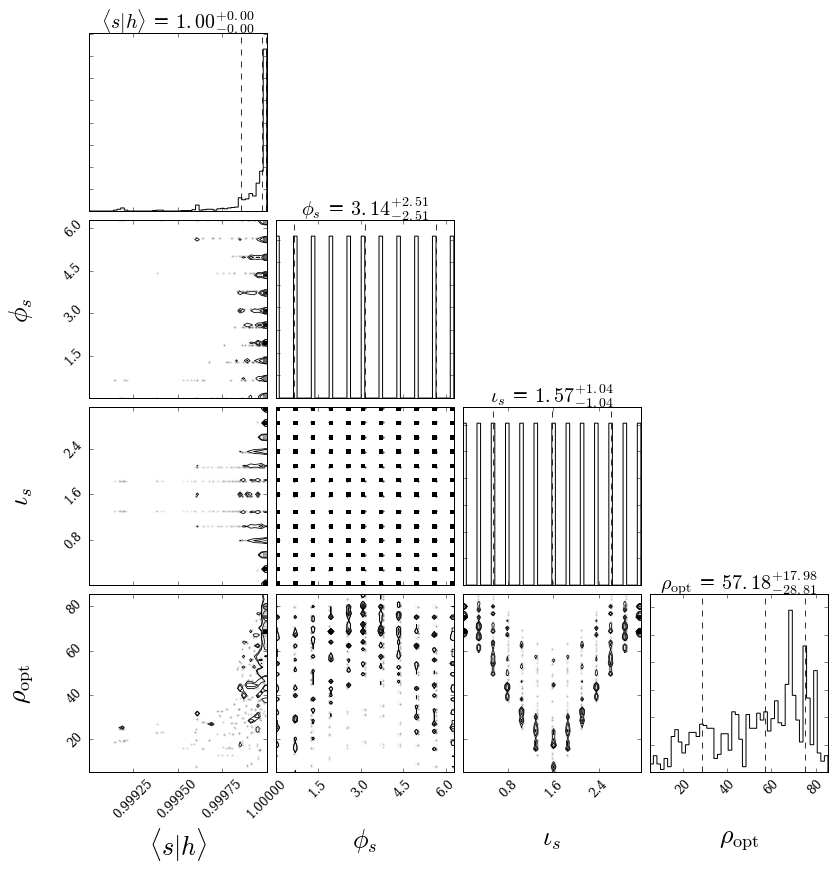

In [68]:
#
import corner

#
X = array( [match_info['samples']['match'],  match_info['samples']['phi_signal'],  match_info['samples']['theta'], match_info['samples']['optsnr']] ).T
print X.shape
c = corner.corner( X, range=[(0.999,1),(0,2*pi),(0,pi),lim(match_info['samples']['optsnr'])], 
                   bins=50,quantiles=[0.16, 0.5, 0.84],
                   labels=[r'$\langle s | h \rangle$',r'$\phi_s$',r'$\iota_s$',r'$\rho_{\mathrm{opt}}$'],
                   show_titles=True )
c.set_size_inches( 12*array([1,1]) )

# c.axes[3].set_ylabel(r'$\iota$')

# c.axes[6].set_xlabel(r'$\rho_{\mathrm{opt}}$')
# c.axes[6].set_ylabel(r'$\langle s_{\mathrm{NR}} | h_{\mathrm{LAL}} \rangle$')

# c.axes[7].set_xlabel(r'$\iota$')
# c.axes[8].set_xlabel(r'$\langle s_{\mathrm{NR}} | h_{\mathrm{LAL}} \rangle$')

savefig( outdir+'matches_'+y.simname+'_corner.pdf',bbox_inches='tight' )